In [ ]:
import os
if not os.path.exists('images'):
    !pip install -qU torch_snippets
    from google.colab import files
    files.upload() # upload kaggle.json
    !mkdir -p ~/.kaggle
    !mv kaggle.json ~/.kaggle/
    !ls ~/.kaggle
    !chmod 600 /root/.kaggle/kaggle.json
    !kaggle datasets download -d andrewmvd/face-mask-detection
    !unzip -qq face-mask-detection.zip
    !rm face-mask-detection.zip

In [ ]:
!pip install timm

In [ ]:
from torch_snippets import *
from torch_snippets import show
from PIL import Image
from sklearn.utils import shuffle
import albumentations as A
import matplotlib
import timm

In [ ]:
!python xml_to_csv.py -i /content/annotations -o /content/df.csv -l /content/

Successfully converted xml to csv.
Generate `/content/label_map.pbtxt`


In [ ]:
df = pd.read_csv('/content/df.csv')
df.head(20)

filename  width  height         class  xmin  ymin  xmax  ymax
0   maksssksksss131.png    400     267     with_mask    65    63   110   112
1   maksssksksss131.png    400     267     with_mask   127    31   166    76
2   maksssksksss131.png    400     267  without_mask   257    55   284    86
3   maksssksksss131.png    400     267     with_mask   284    66   321   107
4   maksssksksss131.png    400     267  without_mask   252   125   295   167
5   maksssksksss131.png    400     267     with_mask   345    93   363   116
6   maksssksksss131.png    400     267  without_mask   236    74   256    99
7   maksssksksss131.png    400     267  without_mask   216    63   237    83
8    maksssksksss97.png    301     400     with_mask   187    83   212   109
9   maksssksksss391.png    400     270     with_mask    93    34   119    61
10  maksssksksss391.png    400     270     with_mask   174    62   199    92
11  maksssksksss391.png    400     270     with_mask   234    91   262   118
12  maksssksksss391.png    400     270     with_mask   305    77   336   108
13  maksssksksss113.png    400     267     with_mask   133   108   148   124
14  maksssksksss113.png    400     267     with_mask   203   117   214   131
15  maksssksksss113.png    400     267     with_mask   294   115   308   130
16  maksssksksss113.png    400     267  without_mask   228   119   241   134
17  maksssksksss704.png    400     267     with_mask     1   162    74   246
18  maksssksksss704.png    400     267     with_mask    49    87    85   138
19  maksssksksss704.png    400     267     with_mask   114    92   172   156

In [ ]:
label2target = {l:t+1 for t,l in enumerate(df['class'].unique())}
label2target['background'] = 0
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']
num_classes = len(label2target)

In [ ]:
label2target

{'background': 0,
 'mask_weared_incorrect': 3,
 'with_mask': 1,
 'without_mask': 2}

In [ ]:
target2label

{0: 'background',
 1: 'with_mask',
 2: 'without_mask',
 3: 'mask_weared_incorrect'}

In [ ]:
path = '/content/images/'

In [ ]:
df

filename  width  height         class  xmin  ymin  xmax  ymax
0     maksssksksss131.png    400     267     with_mask    65    63   110   112
1     maksssksksss131.png    400     267     with_mask   127    31   166    76
2     maksssksksss131.png    400     267  without_mask   257    55   284    86
3     maksssksksss131.png    400     267     with_mask   284    66   321   107
4     maksssksksss131.png    400     267  without_mask   252   125   295   167
...                   ...    ...     ...           ...   ...   ...   ...   ...
4067  maksssksksss167.png    400     210     with_mask    45    69    96   113
4068  maksssksksss167.png    400     210     with_mask   185   113   222   155
4069  maksssksksss167.png    400     210     with_mask   271    32   311    75
4070  maksssksksss167.png    400     210     with_mask    20    90    30   105
4071  maksssksksss810.png    301     400     with_mask   107   277   216   400

[4072 rows x 8 columns]

In [ ]:
df['class_id'] = df['class'].apply(lambda x: label2target[x])

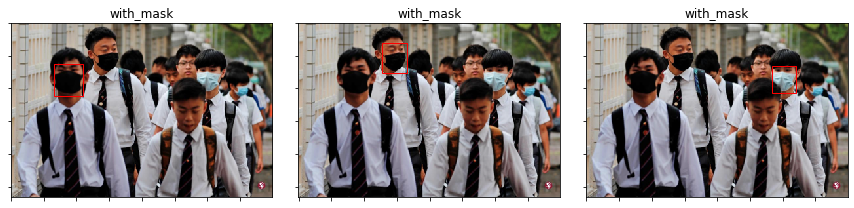

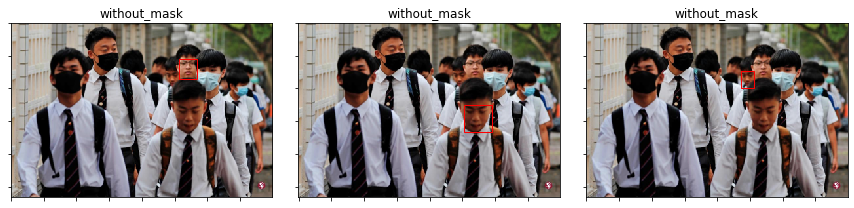

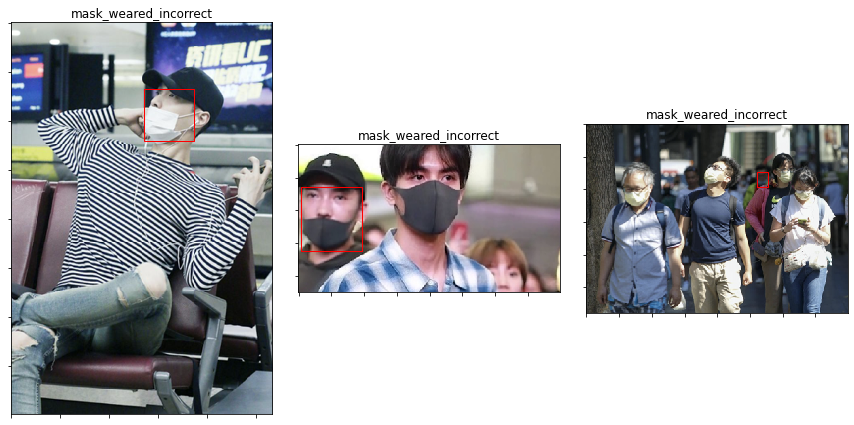

In [ ]:
def plot_example(idx_list):
    fig, axs = plt.subplots(1, 3, figsize=(15, 10))
    fig.subplots_adjust(hspace = .1, wspace=.1)
    axs = axs.ravel()
    for i in range(3):
        image_id = df.loc[idx_list[i], 'filename']
        dim0 = df.loc[idx_list[i], 'width']
        dim1 = df.loc[idx_list[i], 'height']
        img = Image.open('/content/images/'+image_id)
        axs[i].imshow(img,cmap = plt.cm.gray, interpolation ='nearest')
        axs[i].set_title(df.loc[idx_list[i], 'class'])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        if df.loc[idx_list[i], 'class'] != 'No finding':
            bbox = [(df.loc[idx_list[i], 'xmin']),
                    (df.loc[idx_list[i], 'ymin']),
                    (df.loc[idx_list[i], 'xmax']),
                    (df.loc[idx_list[i], 'ymax'])]
            p = matplotlib.patches.Rectangle((bbox[0], bbox[1]),
                                              bbox[2]-bbox[0],
                                              bbox[3]-bbox[1],
                                              ec='r', fc='none', lw=1.)
            axs[i].add_patch(p)
            
for num in range(1, 4):
    idx_list = df[df['class_id']==num][0:3].index.values
    plot_example(idx_list)

In [ ]:
def update_bboxes(df):
    
    df['xmin'] = ((df['xmin'] / df['width'])).astype('float')
    df['ymin'] = ((df['ymin'] / df['height'])).astype('float')
    df['xmax'] = ((df['xmax'] / df['width'])).astype('float')
    df['ymax'] = ((df['ymax'] / df['height'])).astype('float')
    
    return df.reset_index(drop=True)

In [ ]:
df = update_bboxes(df)
df

filename  width  height  ...      xmax      ymax  class_id
0     maksssksksss131.png    400     267  ...  0.275000  0.419476         1
1     maksssksksss131.png    400     267  ...  0.415000  0.284644         1
2     maksssksksss131.png    400     267  ...  0.710000  0.322097         2
3     maksssksksss131.png    400     267  ...  0.802500  0.400749         1
4     maksssksksss131.png    400     267  ...  0.737500  0.625468         2
...                   ...    ...     ...  ...       ...       ...       ...
4067  maksssksksss167.png    400     210  ...  0.240000  0.538095         1
4068  maksssksksss167.png    400     210  ...  0.555000  0.738095         1
4069  maksssksksss167.png    400     210  ...  0.777500  0.357143         1
4070  maksssksksss167.png    400     210  ...  0.075000  0.500000         1
4071  maksssksksss810.png    301     400  ...  0.717608  1.000000         1

[4072 rows x 9 columns]

In [ ]:
def preprocess_image(img):
    img = torch.tensor(img/255).permute(2,0,1)
    return img.to(device).float()

In [ ]:
from torch_snippets import *
from PIL import Image

class covidData(torch.utils.data.Dataset):
  def __init__(self, df, image_dir='/content/images/', transforms=None):
    self.image_dir = image_dir
    self.files = glob.glob(self.image_dir+'*.png')
    self.df = df
    self.image_infos = df.filename.unique()
    self.transforms = transforms

  def __getitem__(self, ix):
    image_id = self.image_infos[ix]
    img_path = find(image_id, self.files)
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    data = df[df['filename'] == image_id]
    data = data.reset_index(drop=True)

    if data.loc[0, "class_id"] == 0:
        data = data.loc[[0], :]
    boxes = data[['xmin','ymin', 'xmax', 'ymax']].values

    area = (boxes[:,2] - boxes[:,0]) * (boxes[:,3] - boxes[:,1])
    labels = data['class_id'].values
    boxes[:,[0,2]] *= 300
    boxes[:,[1,3]] *= 300

    boxes = boxes.astype(np.uint32).tolist()
    target = {}
    target["boxes"] = torch.Tensor(boxes).float()
    target["labels"] = torch.tensor(labels, dtype=torch.int64)
    target["image_id"] = torch.tensor([ix])
    target['area'] = torch.tensor(area, dtype=torch.float32)
    target['iscrowd'] = torch.zeros(labels.shape[0], dtype=torch.int64)

    if self.transforms:
        sample = {
        'image': image,
        'bboxes': target['boxes'],
        'labels': labels}
        
        sample = self.transforms(**sample)
        image = sample['image']
        target['boxes'] = torch.tensor(sample['bboxes'])

    if target["boxes"].shape[0] == 0:
        # Albumentation cuts the target (class 14, 1x1px in the corner)
        target["boxes"] = torch.from_numpy(np.array([[0.0, 0.0, 300.0, 300.0]]))
        target["area"] = torch.tensor([1.0], dtype=torch.float32)
        target["labels"] = torch.tensor([0], dtype=torch.int64)

    
    img = preprocess_image(image)
    return img, target

  def collate_fn(self, batch):
      return tuple(zip(*batch))
    
  def __len__(self):
      return len(self.image_infos)

In [ ]:
train_transform = A.Compose(
    [   A.Resize(300,300),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        #A.RandomCrop(height=224, width=224),
        #A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])

val_transform = A.Compose(
    [   A.Resize(300,300),
        #A.CenterCrop(height=224, width=224),
        #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])

In [ ]:
from sklearn.model_selection import train_test_split
trn_ids, val_ids = train_test_split(df.filename.unique(), test_size=0.7, random_state=88)
trn_df, val_df = df[df['filename'].isin(trn_ids)], df[df['filename'].isin(val_ids)]
len(trn_df), len(val_df)

train_ds = covidData(trn_df, transforms = train_transform)
test_ds = covidData(val_df, transforms = val_transform)
                          
train_loader = DataLoader(train_ds, batch_size=4, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=4, collate_fn=test_ds.collate_fn, drop_last=True)

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def get_model():
    model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [ ]:
# Defining training and validation functions for a single batch
def train_batch(inputs, model, optimizer):
    model.train()
    images, targets = inputs
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optimizer.zero_grad()
    losses = model(images, targets)
    loss = sum(loss for loss in losses.values())
    loss.backward()
    optimizer.step()
    return loss, losses

@torch.no_grad() # this will disable gradient computation in the function below
def validate_batch(inputs, model):
    model.train() # to obtain the losses, model needs to be in train mode only. # #Note that here we are not defining the model's forward method 
#and hence need to work per the way the model class is defined
    images, targets = inputs
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    optimizer.zero_grad()
    losses = model(images, targets)
    loss = sum(loss for loss in losses.values())
    return loss, losses

In [ ]:
model = get_model().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001,
                             weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

n_epochs = 15
log = Report(n_epochs)

In [ ]:
for epoch in range(n_epochs):
    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss, losses = train_batch(inputs, model, optimizer)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
            [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss.item(), 
                   trn_regr_loss=regr_loss.item(), trn_objectness_loss=loss_objectness.item(),
                   trn_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')

    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        loss, losses = validate_batch(inputs, model)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
          [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss.item(), 
                  val_regr_loss=regr_loss.item(), val_objectness_loss=loss_objectness.item(),
                  val_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')
    if (epoch+1)%(n_epochs//5)==0: log.report_avgs(epoch+1)

    print(lr_scheduler.get_last_lr())
    lr_scheduler.step()

EPOCH: 1.000	val_loss: 0.509	val_loc_loss: 0.187	val_regr_loss: 0.290	val_objectness_loss: 0.025	val_rpn_box_reg_loss: 0.007	(35.82s - 501.42s remaining)

[0.0001]

EPOCH: 2.000	val_loss: 0.488	val_loc_loss: 0.188	val_regr_loss: 0.273	val_objectness_loss: 0.019	val_rpn_box_reg_loss: 0.008	(71.05s - 461.85s remaining)

[0.0001]

EPOCH: 3.000	trn_loss: 0.637	trn_loc_loss: 0.269	trn_regr_loss: 0.278	trn_objectness_loss: 0.069	trn_rpn_box_reg_loss: 0.020	val_loss: 0.500	val_loc_loss: 0.198	val_regr_loss: 0.253	val_objectness_loss: 0.036	val_rpn_box_reg_loss: 0.013	(106.12s - 424.49s remaining)


[0.0001]

EPOCH: 4.000	val_loss: 0.343	val_loc_loss: 0.144	val_regr_loss: 0.181	val_objectness_loss: 0.014	val_rpn_box_reg_loss: 0.005	(141.03s - 387.83s remaining)

[1e-05]

EPOCH: 5.000	val_loss: 0.362	val_loc_loss: 0.150	val_regr_loss: 0.198	val_objectness_loss: 0.010	val_rpn_box_reg_loss: 0.005	(175.54s - 351.08s remaining)

[1e-05]

EPOCH: 6.000	trn_loss: 0.556	trn_loc_loss: 0.240	trn_regr_loss: 0.236	trn_objectness_loss: 0.062	trn_rpn_box_reg_loss: 0.017	val_loss: 0.465	val_loc_loss: 0.193	val_regr_loss: 0.231	val_objectness_loss: 0.030	val_rpn_box_reg_loss: 0.011	(210.29s - 315.43s remaining)


[1e-05]

EPOCH: 7.000	val_loss: 0.357	val_loc_loss: 0.156	val_regr_loss: 0.182	val_objectness_loss: 0.013	val_rpn_box_reg_loss: 0.005	(244.91s - 279.89s remaining)

[1.0000000000000002e-06]

EPOCH: 8.000	val_loss: 0.356	val_loc_loss: 0.153	val_regr_loss: 0.183	val_objectness_loss: 0.015	val_rpn_box_reg_loss: 0.005	(279.63s - 244.68s remaining)

[1.0000000000000002e-06]

EPOCH: 9.000	trn_loss: 0.554	trn_loc_loss: 0.239	trn_regr_loss: 0.241	trn_objectness_loss: 0.058	trn_rpn_box_reg_loss: 0.017	val_loss: 0.462	val_loc_loss: 0.193	val_regr_loss: 0.228	val_objectness_loss: 0.030	val_rpn_box_reg_loss: 0.011	(314.63s - 209.76s remaining)


[1.0000000000000002e-06]

EPOCH: 10.000	val_loss: 0.360	val_loc_loss: 0.158	val_regr_loss: 0.183	val_objectness_loss: 0.014	val_rpn_box_reg_loss: 0.005	(349.31s - 174.66s remaining)

[1.0000000000000002e-07]

EPOCH: 11.000	val_loss: 0.361	val_loc_loss: 0.158	val_regr_loss: 0.183	val_objectness_loss: 0.015	val_rpn_box_reg_loss: 0.005	(384.05s - 139.66s remaining)

[1.0000000000000002e-07]

EPOCH: 12.000	trn_loss: 0.547	trn_loc_loss: 0.238	trn_regr_loss: 0.237	trn_objectness_loss: 0.055	trn_rpn_box_reg_loss: 0.017	val_loss: 0.463	val_loc_loss: 0.194	val_regr_loss: 0.228	val_objectness_loss: 0.030	val_rpn_box_reg_loss: 0.011	(418.84s - 104.71s remaining)


[1.0000000000000002e-07]

EPOCH: 13.000	val_loss: 0.357	val_loc_loss: 0.157	val_regr_loss: 0.183	val_objectness_loss: 0.012	val_rpn_box_reg_loss: 0.005	(453.91s - 69.83s remaining)

[1.0000000000000004e-08]

EPOCH: 14.000	val_loss: 0.362	val_loc_loss: 0.157	val_regr_loss: 0.183	val_objectness_loss: 0.017	val_rpn_box_reg_loss: 0.005	(488.81s - 34.91s remaining)

[1.0000000000000004e-08]

EPOCH: 15.000	trn_loss: 0.567	trn_loc_loss: 0.241	trn_regr_loss: 0.231	trn_objectness_loss: 0.071	trn_rpn_box_reg_loss: 0.024	val_loss: 0.462	val_loc_loss: 0.194	val_regr_loss: 0.228	val_objectness_loss: 0.029	val_rpn_box_reg_loss: 0.011	(523.55s - 0.00s remaining)


[1.0000000000000004e-08]

100%|██████████| 116/116 [00:00<00:00, 1251.82it/s]


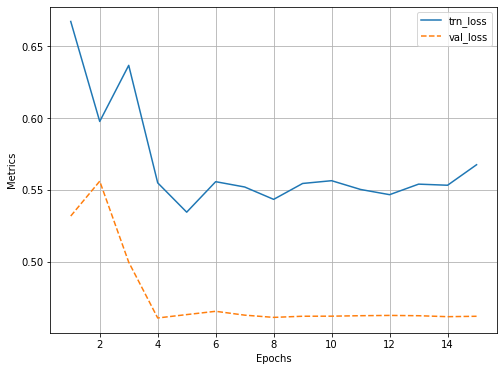

In [ ]:
log.plot_epochs(['trn_loss','val_loss'])

In [ ]:
from torchvision.ops import nms
def decode_output(output):
    'convert tensors to numpy arrays'
    bbs = output['boxes'].cpu().detach().numpy().astype(np.uint32)
    labels = np.array([target2label[i] for i in output['labels'].cpu().detach().numpy()])
    confs = output['scores'].cpu().detach().numpy()
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    bbs, confs, labels = [tensor[ixs] for tensor in [bbs, confs, labels]]

    if len(ixs) == 1:
        bbs, confs, labels = [np.array([tensor]) for tensor in [bbs, confs, labels]]
    return bbs.tolist(), confs.tolist(), labels.tolist()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


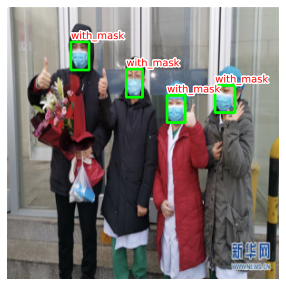

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


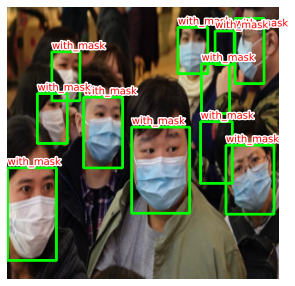

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


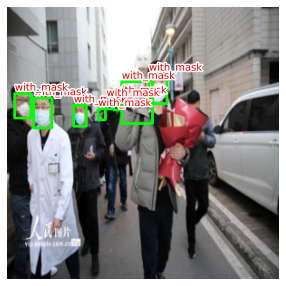

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


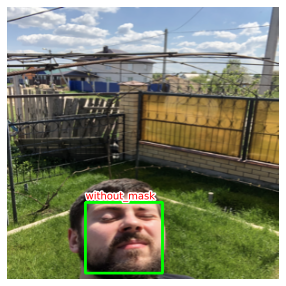

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


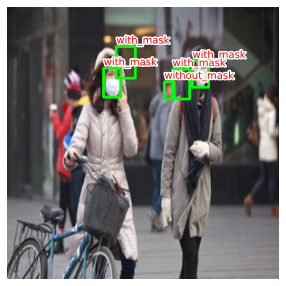

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


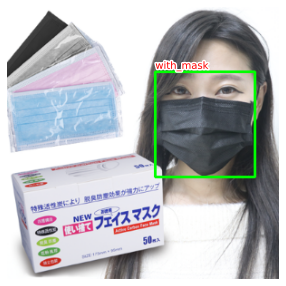

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


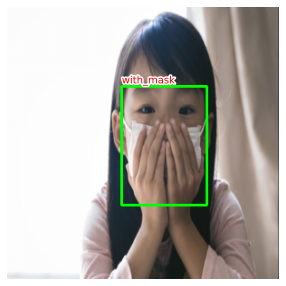

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


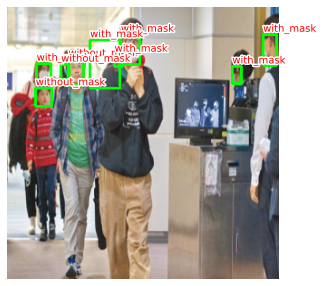

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


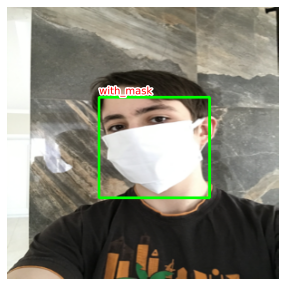

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


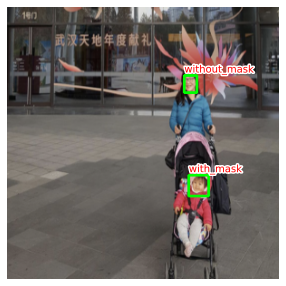

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


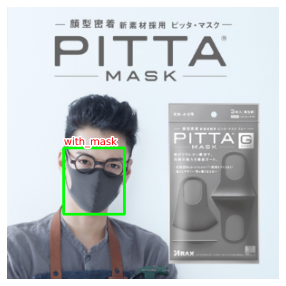

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


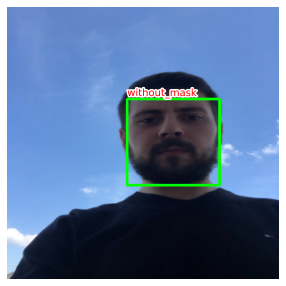

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


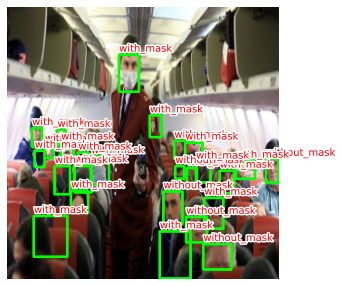

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


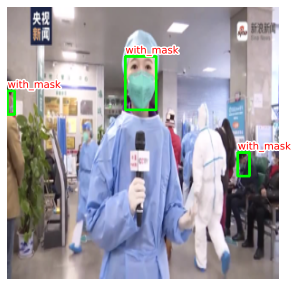

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


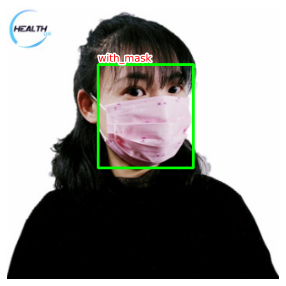

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


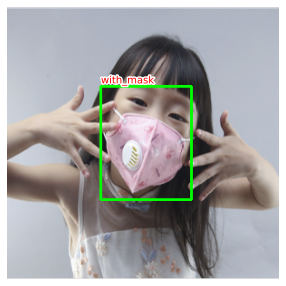

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


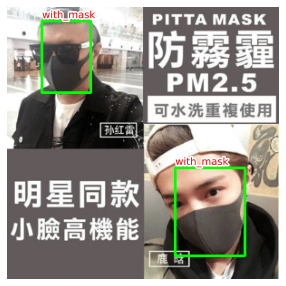

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


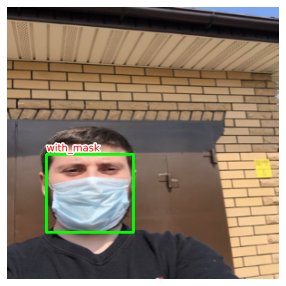

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


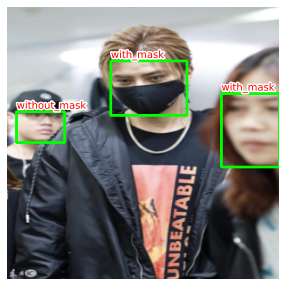

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


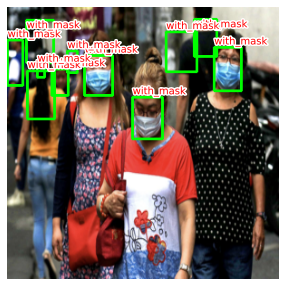

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


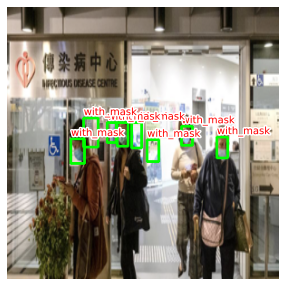

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


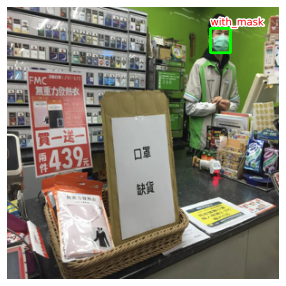

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


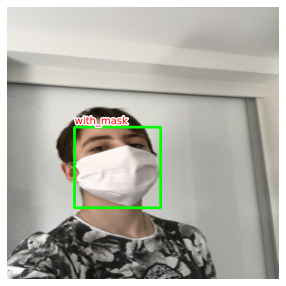

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


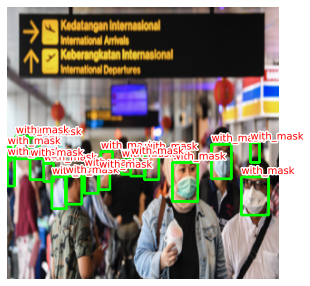

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


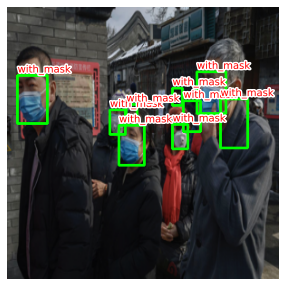

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


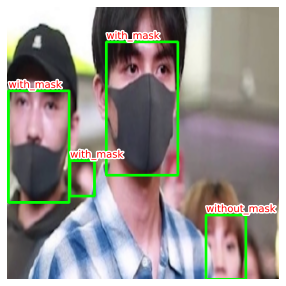

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


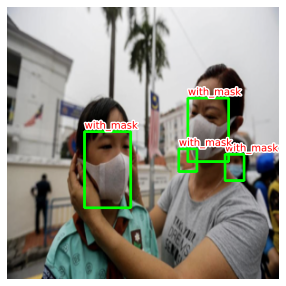

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


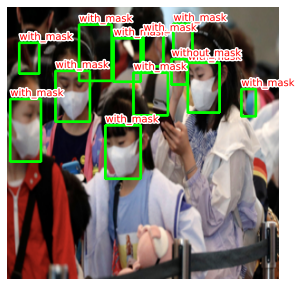

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


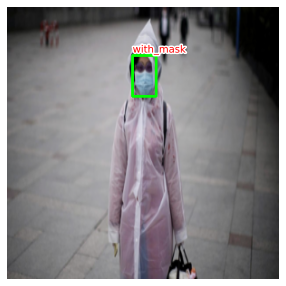

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


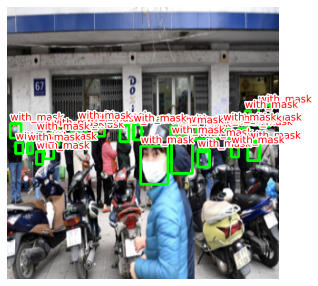

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


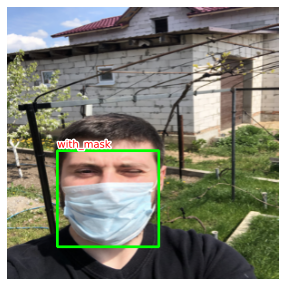

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


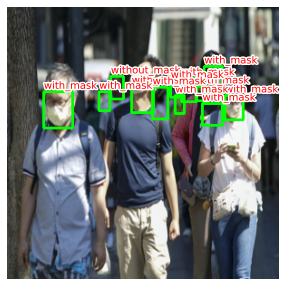

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


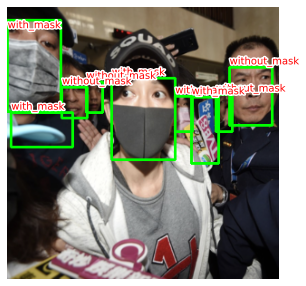

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


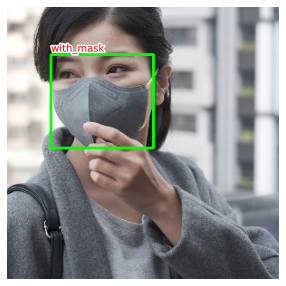

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


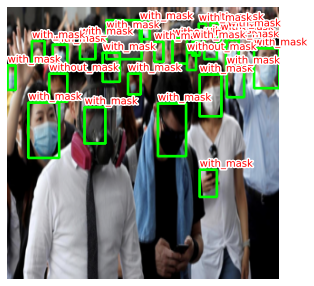

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


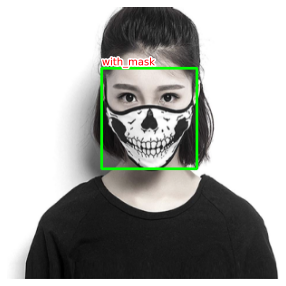

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


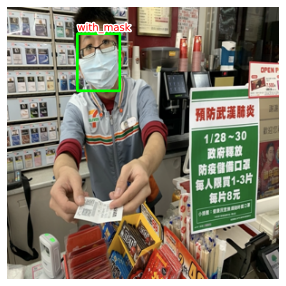

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


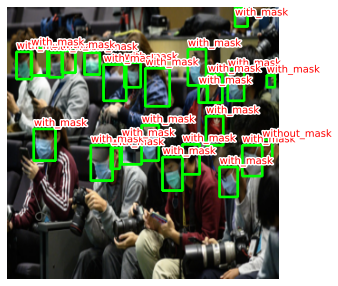

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


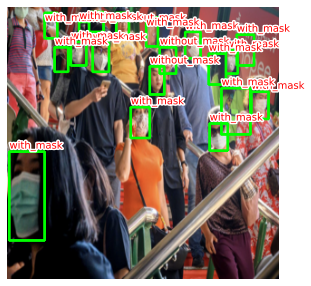

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


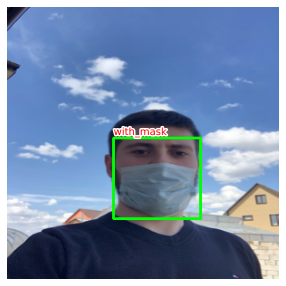

In [ ]:
model.eval()
for ix, (images, targets) in enumerate(test_loader):
    if ix==10: break
    images = [im for im in images]
    outputs = model(images)
    for ix, output in enumerate(outputs):
        bbs, confs, labels = decode_output(output)
        info = [f'{l}@{c:.2f}' for l,c in zip(labels, confs)]
        show(images[ix].cpu().permute(1,2,0), bbs=bbs, texts=labels, sz=5)

In [ ]:
torch.save(model, '/content/drive/MyDrive/modelpycovid.pth')